### CLs limit with MC toys

Open the `ROOT` file

In [1]:
TFile* f = TFile::Open("model.root") ;


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



Retrieve the workspace

In [2]:
RooWorkspace* w = (RooWorkspace*) f->Get("w") ;
w->Print() ;


RooWorkspace(w) w contents

variables
---------
(B,Nobs_CR,Nobs_SR,S,mu,tau)

p.d.f.s
-------
RooProdPdf::model[ model_SR * model_CR ] = 0.00144134
RooPoisson::model_CR[ x=Nobs_CR mean=Nexp_CR ] = 0.0281977
RooPoisson::model_SR[ x=Nobs_SR mean=Nexp_SR ] = 0.0511153

functions
--------
RooFormulaVar::Nexp_CR[ actualVars=(tau,B) formula="tau*B" ] = 200
RooFormulaVar::Nexp_SR[ actualVars=(mu,S,B) formula="mu*S+B" ] = 30

datasets
--------
RooDataSet::observed_data(Nobs_SR,Nobs_CR)

parameter snapshots
-------------------
ModelConfig__snapshot = (mu=1)

named sets
----------
ModelConfig_NuisParams:(B)
ModelConfig_Observables:(Nobs_SR,Nobs_CR)
ModelConfig_POI:(mu)
ModelConfig__snapshot:(mu)
obs:(Nobs_SR,Nobs_CR)

generic objects
---------------
RooStats::ModelConfig::ModelConfig



#### Retrieve the ModelConfig for the S+B hypothesis

Retrieve the ModelConfig and the observed data. Together these uniquely define the statistical problem

In [3]:
RooAbsData* data = w->data("observed_data") ;
RooStats::ModelConfig* sbModel = (RooStats::ModelConfig*) w->obj("ModelConfig") ;  

#### Construct a ModelConfig for the B-only hypothesis

For a CLS-style limit calculation (hypothesis test inversion) we need an explicit specification of the background-only hypothesis == another RooStats::ModelConfig that describe the B-only scenario  

In [4]:
RooStats::ModelConfig* bModel = (RooStats::ModelConfig*) sbModel->Clone("BonlyModel") ;

Here we take a little shortcut from universality by assuming that the POI=0 scenario corresponds to the background-only scenario

Set value POI parameter to zero

In [5]:
RooRealVar* poi = (RooRealVar*) bModel->GetParametersOfInterest()->first();
poi->setVal(0) ;

Configure bModel to encode current poi=0 scenario as its hypothesis 

In [6]:
bModel->SetSnapshot( *poi  );

*NB: To make CLS-style hypothesis calculation macros truly universal workspace files should contain both ModelConfigs upfront*

#### Construct an hypothesis p-value calculator
i.e the calculation of p(sbModel) and p(bModel) for the observed data

Instantiate hypothesis testing calculator assuming asymptotic distributions of the profile likelihood ratio (`PLR`) test statistic. This calculator is much more time consuming than the asymptotic calculator but is also valid in the low statistics regime.

In [7]:
RooStats::FrequentistCalculator  freqCalc(*data, *bModel, *sbModel);

The frequentist calculator is more general than the asymptotic calculator: it can calculate distributions for _any_ test statistic. So here we have to tell it that we want the profile likelihood ratio test statistic

In [8]:
RooStats::ProfileLikelihoodTestStat* plr = new RooStats::ProfileLikelihoodTestStat(*sbModel->GetPdf());

Configure calculator for a limit (=one-sided interval)

In [9]:
plr->SetOneSided(true); 

Specifically we have to tell the Toy MC sampler part of the calculator what the relevant test statistic is

In [10]:
RooStats::ToyMCSampler* toymcs = (RooStats::ToyMCSampler*) freqCalc.GetTestStatSampler();
toymcs->SetTestStatistic(plr);

If we use the frequentist calculator for counting experiments (instead of models of distributions) we should instruct the sampler to generate one event for each toy. ( This is the case because we model counting experiments in RooFit as a single observation in distribution of event counts. )

In [11]:
if (!sbModel->GetPdf()->canBeExtended()) {
    toymcs->SetNEventsPerToy(1);
}

Sample 1000 toys for SB and B hypothesis respectively to model their distributions (Here you can trade speed vs accuracy)

In [12]:
freqCalc.SetToys(1000,1000) ;

#### Construct an hypothesis test inverter

i.e. a tool that can calculate the POI value for which (in this case) CLS==$p(\mathrm{sbModel})/(1-p(\mathrm{Model}))$ takes a certain value. This inversion requires a scan over possible values of $\mu$.

In [13]:
RooStats::HypoTestInverter inverter(freqCalc);

[#1] INFO:InputArguments -- HypoTestInverter ---- Input models: 
		 using as S+B (null) model     : ModelConfig
		 using as B (alternate) model  : BonlyModel



Statistical configuration of hypothesis test inverter

In [14]:
inverter.SetConfidenceLevel(0.90);
inverter.UseCLs(true); 

Technical configuration of hypothesis test inverter

In [15]:
inverter.SetVerbose(false);
inverter.SetFixedScan(30,0.0,6.0); // set number of points , xmin and xmax 

Perform calculation of limit

In [16]:
RooStats::HypoTestInverterResult* result =  inverter.GetInterval();

[#1] INFO:Eval -- HypoTestInverter::GetInterval - run a fixed scan
[#1] INFO:ObjectHandling -- RooWorkspace::saveSnaphot(w) replacing previous snapshot with name ModelConfig__snapshot

=== Using the following for ModelConfig ===
Observables:             RooArgSet:: = (Nobs_SR,Nobs_CR)
Parameters of Interest:  RooArgSet:: = (mu)
Nuisance Parameters:     RooArgSet:: = (B)
PDF:                     RooProdPdf::model[ model_SR * model_CR ] = 0.00125727
Snapshot:                
  1) 0x7f8391561690 RooRealVar:: mu = 0  L(-1 - 10)  "mu"


=== Using the following for BonlyModel ===
Observables:             RooArgSet:: = (Nobs_SR,Nobs_CR)
Parameters of Interest:  RooArgSet:: = (mu)
Nuisance Parameters:     RooArgSet:: = (B)
PDF:                     RooProdPdf::model[ model_SR * model_CR ] = 0.00125727
Snapshot:                
  1) 0x7f8391561690 RooRealVar:: mu = 0  L(-1 - 10)  "mu"

[#0] PROGRESS:Generation -- Test Statistic on data: 0
[#1] INFO:InputArguments -- Profiling conditional MLEs fo

[#0] PROGRESS:Generation -- generated toys: 500 / 1000
[#1] INFO:InputArguments -- Profiling conditional MLEs for Alt.
[#1] INFO:InputArguments -- Using a ToyMCSampler. Now configuring for Alt.
[#0] PROGRESS:Generation -- generated toys: 500 / 1000
[#1] INFO:ObjectHandling -- RooWorkspace::saveSnaphot(w) replacing previous snapshot with name ModelConfig__snapshot

=== Using the following for ModelConfig ===
Observables:             RooArgSet:: = (Nobs_SR,Nobs_CR)
Parameters of Interest:  RooArgSet:: = (mu)
Nuisance Parameters:     RooArgSet:: = (B)
PDF:                     RooProdPdf::model[ model_SR * model_CR ] = 0.000529598
Snapshot:                
  1) 0x7f8391624430 RooRealVar:: mu = 1.44828  L(-1 - 10)  "mu"


=== Using the following for BonlyModel ===
Observables:             RooArgSet:: = (Nobs_SR,Nobs_CR)
Parameters of Interest:  RooArgSet:: = (mu)
Nuisance Parameters:     RooArgSet:: = (B)
PDF:                     RooProdPdf::model[ model_SR * model_CR ] = 0.000529598
Snapsh

[#0] PROGRESS:Generation -- generated toys: 500 / 1000
[#1] INFO:InputArguments -- Profiling conditional MLEs for Alt.
[#1] INFO:InputArguments -- Using a ToyMCSampler. Now configuring for Alt.
[#0] PROGRESS:Generation -- generated toys: 500 / 1000
[#1] INFO:ObjectHandling -- RooWorkspace::saveSnaphot(w) replacing previous snapshot with name ModelConfig__snapshot

=== Using the following for ModelConfig ===
Observables:             RooArgSet:: = (Nobs_SR,Nobs_CR)
Parameters of Interest:  RooArgSet:: = (mu)
Nuisance Parameters:     RooArgSet:: = (B)
PDF:                     RooProdPdf::model[ model_SR * model_CR ] = 1.7433e-06
Snapshot:                
  1) 0x7f839172c370 RooRealVar:: mu = 2.89655  L(-1 - 10)  "mu"


=== Using the following for BonlyModel ===
Observables:             RooArgSet:: = (Nobs_SR,Nobs_CR)
Parameters of Interest:  RooArgSet:: = (mu)
Nuisance Parameters:     RooArgSet:: = (B)
PDF:                     RooProdPdf::model[ model_SR * model_CR ] = 1.7433e-06
Snapshot

[#0] PROGRESS:Generation -- generated toys: 500 / 1000
[#1] INFO:InputArguments -- Profiling conditional MLEs for Alt.
[#1] INFO:InputArguments -- Using a ToyMCSampler. Now configuring for Alt.
[#0] PROGRESS:Generation -- generated toys: 500 / 1000
[#1] INFO:ObjectHandling -- RooWorkspace::saveSnaphot(w) replacing previous snapshot with name ModelConfig__snapshot

=== Using the following for ModelConfig ===
Observables:             RooArgSet:: = (Nobs_SR,Nobs_CR)
Parameters of Interest:  RooArgSet:: = (mu)
Nuisance Parameters:     RooArgSet:: = (B)
PDF:                     RooProdPdf::model[ model_SR * model_CR ] = 5.81873e-10
Snapshot:                
  1) 0x7f83916049a0 RooRealVar:: mu = 4.34483  L(-1 - 10)  "mu"


=== Using the following for BonlyModel ===
Observables:             RooArgSet:: = (Nobs_SR,Nobs_CR)
Parameters of Interest:  RooArgSet:: = (mu)
Nuisance Parameters:     RooArgSet:: = (B)
PDF:                     RooProdPdf::model[ model_SR * model_CR ] = 5.81873e-10
Snapsh

[#0] PROGRESS:Generation -- generated toys: 500 / 1000
[#1] INFO:InputArguments -- Profiling conditional MLEs for Alt.
[#1] INFO:InputArguments -- Using a ToyMCSampler. Now configuring for Alt.
[#0] PROGRESS:Generation -- generated toys: 500 / 1000
[#1] INFO:ObjectHandling -- RooWorkspace::saveSnaphot(w) replacing previous snapshot with name ModelConfig__snapshot

=== Using the following for ModelConfig ===
Observables:             RooArgSet:: = (Nobs_SR,Nobs_CR)
Parameters of Interest:  RooArgSet:: = (mu)
Nuisance Parameters:     RooArgSet:: = (B)
PDF:                     RooProdPdf::model[ model_SR * model_CR ] = 5.09696e-14
Snapshot:                
  1) 0x7f8391b953d0 RooRealVar:: mu = 5.7931  L(-1 - 10)  "mu"


=== Using the following for BonlyModel ===
Observables:             RooArgSet:: = (Nobs_SR,Nobs_CR)
Parameters of Interest:  RooArgSet:: = (mu)
Nuisance Parameters:     RooArgSet:: = (B)
PDF:                     RooProdPdf::model[ model_SR * model_CR ] = 5.09696e-14
Snapsho

Print observed limit

In [17]:
cout << 100*inverter.ConfidenceLevel() << "%  upper limit : " << result->UpperLimit() << endl;

90%  upper limit : 1.29286


compute expected limit

In [18]:
std::cout << "Expected upper limits, using the B (alternate) model : " << std::endl;
std::cout << " expected limit (median) " << result->GetExpectedUpperLimit(0) << std::endl;
std::cout << " expected limit (-1 sig) " << result->GetExpectedUpperLimit(-1) << std::endl;
std::cout << " expected limit (+1 sig) " << result->GetExpectedUpperLimit(1) << std::endl;
std::cout << " expected limit (-2 sig) " << result->GetExpectedUpperLimit(-2) << std::endl;
std::cout << " expected limit (+2 sig) " << result->GetExpectedUpperLimit(2) << std::endl;

Expected upper limits, using the B (alternate) model : 
 expected limit (median) 0.869595
 expected limit (-1 sig) 0.640249
 expected limit (+1 sig) 1.27409
 expected limit (-2 sig) 0.534798
 expected limit (+2 sig) 1.79995


Use the visualization tool of the PLC to show how the interval was calculated

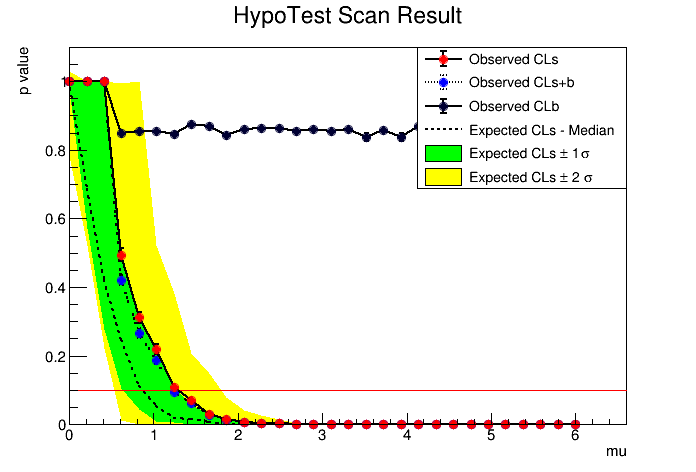

In [19]:
TCanvas* c1 = new TCanvas();
RooStats::HypoTestInverterPlot* plot = new RooStats::HypoTestInverterPlot("HTI_Result_Plot","HypoTest Scan Result",result);
plot->Draw("CLb 2CL");  // plot also CLb and CLs+b 
c1->Draw()